# Importing necessary libraries

In [119]:
import numpy as np  
import pandas as pd 
import re       
from keras.preprocessing.text import Tokenizer 
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [120]:
!pip install transformers

# Reading in the data 

In [121]:
df = pd.read_csv('Books_rating.csv')
df.head(4)

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,"This is only for Julie Strain fans. It's a collection of her photos -- about 80 pages worth with a nice section of paintings by Olivia.If you're looking for heavy literary content, this isn't the ..."
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after reading Philip Nel's book I changed my mind--that's a good testimonial to the power of Rel's writing and thinking. Rel plays Dr. Seuss the ultimate compli...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""the child is father to the man,"" then Dr. Seuss (Theodor Seuss Geisel) is the most influential author, poet, and artist of modern times. For me, a dadd..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;Dr. Seuss,&quot; was one of the most influential writers and artists of the 20th century.In 1959, Rudolf Flesch wrote, &quot;A hundred years from now, ..."


In [122]:
df.columns
df_1 = df.copy()
df_2 = df_1[["review/text","review/summary"]]

## Data info and description

In [123]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 2 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   review/text     object
 1   review/summary  object
dtypes: object(2)
memory usage: 45.8+ MB


In [124]:
df_2.describe()

,review/text,review/summary
count,2999992,2999962
unique,2062648,1592315
top,digital books are perfect and easy to use! They take up no space on the bookshelf and are always with you!!!,Great Book
freq,322,6848


# Renaming the two necessary columns

In [125]:
df_2.rename(columns={"review/text":"text", "review/summary":"summary"}, inplace=True)
df_2

,text,summary
0,"This is only for Julie Strain fans. It's a collection of her photos -- about 80 pages worth with a nice section of paintings by Olivia.If you're looking for heavy literary content, this isn't the ...",Nice collection of Julie Strain images
1,I don't care much for Dr. Seuss but after reading Philip Nel's book I changed my mind--that's a good testimonial to the power of Rel's writing and thinking. Rel plays Dr. Seuss the ultimate compli...,Really Enjoyed It
2,"If people become the books they read and if ""the child is father to the man,"" then Dr. Seuss (Theodor Seuss Geisel) is the most influential author, poet, and artist of modern times. For me, a dadd...",Essential for every personal and Public Library
3,"Theodore Seuss Geisel (1904-1991), aka &quot;Dr. Seuss,&quot; was one of the most influential writers and artists of the 20th century.In 1959, Rudolf Flesch wrote, &quot;A hundred years from now, ...",Phlip Nel gives silly Seuss a serious treatment
4,"Philip Nel - Dr. Seuss: American IconThis is basically an academic overview of Seuss poetry, art, cartoons, and the problems with the commercialization of the Seuss name and works after his death....",Good academic overview
...,...,...
2999995,"This is an extremely difficult book to digest, and it is not for casual readers. However, Collingwood's ideas on a meeting of minds between past and present is absolutely fascinating and gets to t...",Difficult
2999996,This is pretty interesting. Collingwood seems like on of the first historians to really utilize ideas from evolutionary theory and modern psychology in his overall method. He manages to create a v...,Quite good and ahead of its time occasionally
2999997,"This is a good book but very esoteric. ""What is History?"" by E.H. Carr is an easier selection for the causal reader or someone beginning to study historiography.",Easier reads of those not well versed in historiography
2999998,"My daughter, a freshman at Indiana University, e-mailed me a list of the books she needed. This was on it... I ordered it, paid for it, and had it shipped directly to her. It arrived sooner than e...","Yes, it is cheaper than the University Bookstore"


In [126]:
df_2.dropna(how='any', inplace=True)

# Limiting the rows of the data to 100000

### This eradicates longer runtime.

In [127]:
df_3 = df_2[:100000]

# Installing necessary libraries

In [128]:
!pip install datasets nltk rouge_score

# Rouge score calculation function

In [129]:
from datasets import load_metric
metric = load_metric("rouge")

def calc_rouge_scores(candidates, references):
    result = metric.compute(predictions=candidates, references=references, use_stemmer=True)
    result = {key: round(value.mid.fmeasure * 100, 1) for key, value in result.items()}
    return result

# creating a BASELINE Model and calculating the Rouge score

In [130]:
import re

ref_summaries = list(df_3['summary'])

for i in range (3):
    candidate_summaries = list(df_3['text'].apply(lambda x: ' '.join(re.split(r'(?<=[.:;])\s', x)[:i+1])))
    print(f"First {i+1} senctences: Scores {calc_rouge_scores(candidate_summaries, ref_summaries)}")

First 1 senctences: Scores {'rouge1': 10.8, 'rouge2': 3.1, 'rougeL': 9.9, 'rougeLsum': 9.9}
First 2 senctences: Scores {'rouge1': 9.0, 'rouge2': 2.4, 'rougeL': 8.0, 'rougeLsum': 8.0}
First 3 senctences: Scores {'rouge1': 7.7, 'rouge2': 2.0, 'rougeL': 6.7, 'rougeLsum': 6.7}


# Text Preprocessing

###     - Removing extra white spaces
###     - Expand contractions
###     - Remove special case characters
###     - Lowercasing all letters

### Dictionary to be used for expanding contractions

In [131]:

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [133]:
# for text
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in df_3['text']:
    cleaned_text.append(text_cleaner(t))

In [134]:
# for summary
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in df_3['summary']:
    cleaned_summary.append(summary_cleaner(t))

df_3['cleaned_text']=cleaned_text
df_3['cleaned_summary']=cleaned_summary
df_3['cleaned_summary'].replace('', np.nan, inplace=True)
df_3.dropna(axis=0,inplace=True)

### Adding tokens to the start and end of the summary column

In [135]:
df_3['cleaned_summary'] = df_3['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [136]:
for i in range(5):
    print("Review:",df_3['cleaned_text'][i])
    print("Summary:",df_3['cleaned_summary'][i])
    print("\n")

Review: julie strain fans collection photos pages worth nice section paintings olivia looking heavy literary content place find pages text everything else photos bottom line want one book six foot one probably better choice however like julie like like julie wrong one either
Summary: _START_ nice collection of julie strain images  _END_


Review: care much seuss reading philip nel book changed mind good testimonial power rel writing thinking rel plays seuss ultimate compliment treating serious poet well one century interesting visual artists reading book decided trip mandeville collections library university california san diego order could visit incredible seuss geisel holdings almost much take like william butler yeats seuss led career constantly shifted metamoprhized meet new historical political cirsumstances seems leftist conservative different junctures career politics art nel shows cartoonist fabled magazine like andy warhol served time slaving business service amusing broadenin

##### Plotting the distribution sequence

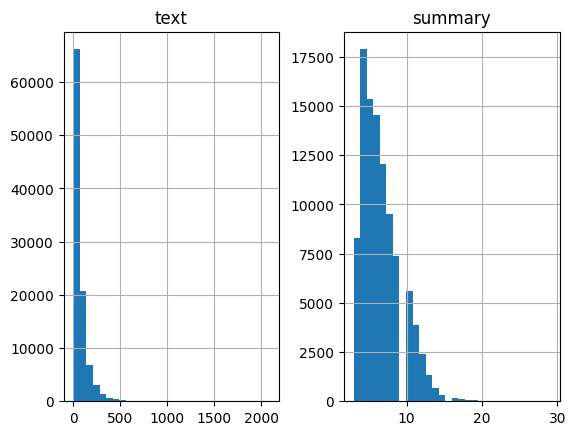

In [137]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df_3['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in df_3['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

# Getting the percentile values of the word count of text.

In [138]:
df_3['word count text'] = df_3['text'].apply(lambda x : len(str(x).split()))
for i in range(0,100,10):
    var = df_3['word count text'].values
    var = np.sort(var, axis=None)
    print('{} percentile value is {}'.format(i, var[int(len(var)*(float(i)/100))]))
print('100 percentile value is ', var[-1])



print(' FROM 90 TO 100')


for i in range(90,100):
    var = df_3['word count text'].values
    var = np.sort(var, axis=None)
    print('{} percentile value is {}'.format(i, var[int(len(var)*(float(i)/100))]))
print('100 percentile value is ', var[-1])

0 percentile value is 1
10 percentile value is 27
20 percentile value is 41
30 percentile value is 57
40 percentile value is 74
50 percentile value is 95
60 percentile value is 121
70 percentile value is 157
80 percentile value is 213
90 percentile value is 323
100 percentile value is  4928
 FROM 90 TO 100
90 percentile value is 323
91 percentile value is 341
92 percentile value is 363
93 percentile value is 389
94 percentile value is 419
95 percentile value is 455
96 percentile value is 499
97 percentile value is 554
98 percentile value is 640
99 percentile value is 793
100 percentile value is  4928


### For summary

In [139]:
df_3['word count summary'] = df_3['summary'].apply(lambda x : len(str(x).split()))
for i in range(0,100,10):
    var = df_3['word count summary'].values
    var = np.sort(var, axis=None)
    print('{} percentile value is {}'.format(i, var[int(len(var)*(float(i)/100))]))
print('100 percentile value is ', var[-1])



print(' FROM 90 TO 100')


for i in range(90,100):
    var = df_3['word count summary'].values
    var = np.sort(var, axis=None)
    print('{} percentile value is {}'.format(i, var[int(len(var)*(float(i)/100))]))
print('100 percentile value is ', var[-1])

0 percentile value is 1
10 percentile value is 2
20 percentile value is 2
30 percentile value is 3
40 percentile value is 4
50 percentile value is 4
60 percentile value is 5
70 percentile value is 6
80 percentile value is 7
90 percentile value is 9
100 percentile value is  26
 FROM 90 TO 100
90 percentile value is 9
91 percentile value is 9
92 percentile value is 9
93 percentile value is 9
94 percentile value is 10
95 percentile value is 10
96 percentile value is 10
97 percentile value is 11
98 percentile value is 12
99 percentile value is 13
100 percentile value is  26


In [140]:
# Setting the maximum for both text and summary

max_count_text = 80
max_count_summary = 10

In [141]:
# Splitting the dataset with train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_3['text'], df_3['summary'], test_size=0.3, random_state=23)

## Tokenization

#### _Changing_ and _Passing_ the text values into a more understandable format for the model
#### Tokenizing both _text_ and _summary_ columns

In [142]:
# for text
#prepare a tokenizer for text on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

#convert text sequences into integer sequences
x_train    =   x_tokenizer.texts_to_sequences(x_train) 
x_test   =   x_tokenizer.texts_to_sequences(x_test)

#padding zero upto maximum length
x_train    =   pad_sequences(x_train,  maxlen=max_count_text, padding='post') 
x_test   =   pad_sequences(x_test, maxlen=max_count_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [143]:

#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

#convert summary sequences into integer sequences
y_train    =   y_tokenizer.texts_to_sequences(y_train) 
y_test   =   y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_train    =   pad_sequences(y_train, maxlen=max_count_summary, padding='post')
y_test   =   pad_sequences(y_test, maxlen=max_count_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

### BUILDING THE MODEL

In [144]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_count_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

# Attention Layer
# Attention layer attn_layer = AttentionLayer(name='attention_layer') 
# attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
# decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_outputs) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 500)      63956500    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 80, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

## Loss function

### Using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly.
### This preserves/ solves memory issues 

In [145]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

## Early stopping

###  It is used to stop training the neural network at the right time by monitoring a user-specified metric.
###  Monitoring the validation loss (val_loss). The model will stop training once the validation loss increases

In [146]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [147]:
# history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

### Diagnostic Plot

#### To understand the behaviour of the model over time.

In [148]:
# from matplotlib import pyplot 
# pyplot.plot(history.history['loss'], label='train') 
# pyplot.plot(history.history['val_loss'], label='test') 
# pyplot.legend()
# pyplot.show()

### Building dictionary to convert the index to word for target and source vocabulary

In [149]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

### Setting up inference for encoder and decoder

In [150]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_count_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# #attention inference
# attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

#### Decode Sequence Function

In [151]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_count_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

#### Defining the functions to convert an integer sequence to a word sequence for summary as well as the reviews.

In [152]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

#### Testing the model

In [153]:
for i in range(10):
  print("Review:",seq2text(x_test[i]))
  print("Original summary:",seq2summary(y_test[i]))
  print("Predicted summary:",decode_sequence(x_test[i].reshape(1,max_count_text)))
  print("\n")

Review: i love edgar allan poe i enjoyed reading him in school and enjoy reading him today i love having this on my kindle 
Original summary: i love edgar 
1/1 [==============================] - 0s 51ms/step
Predicted summary:  horeseman acton orrigina pawn copies copies copies frank's mankind


Review: for a bookclub there were so many different abridged versions that i finally gave up and bought the unabridged i am so glad i did my husband and i both read and loved this book it's a great translation and i would definitely recommend the unabridged version it was interesting in my bookclub to hear all of the different plot lines left out of the various abridged versions some of them were pretty pivotal i'd stick with this great version 
Original summary: loved this book 
1/1 [==============================] - 0s 68ms/step
Predicted summary:  dogs nerd 1500 pitiable capitol horrid horrid infrequent infrequent


Review: a great book to read i enjoy reading about the mennonites and there 